In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d akshaydattatraykhare/diabetes-dataset

Dataset URL: https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset
License(s): CC0-1.0
diabetes-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/diabetes-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV


In [5]:
diabetes = pd.read_csv('/content/diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
diabetes.shape

(768, 9)

In [7]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
diabetes.isna().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [10]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = diabetes['Insulin'].quantile(0.25)
Q3 = diabetes['Insulin'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")

Q1: 0.0, Q3: 127.25, IQR: 127.25


In [11]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = 450

print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Identify outliers
outliers = diabetes[(diabetes['Insulin'] < lower_bound) | (diabetes['Insulin'] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
diabetes['Insulin'] = diabetes['Insulin'].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

Lower Bound: -190.875, Upper Bound: 450
Number of outliers: 17


In [12]:
diabetes['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [13]:
diabetes.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,67.424000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,96.212687,35.142537,0.550500,37.067164


             count
Pregnancies       
1              135
0              111
2              103
3               75
4               68
5               57
6               50
7               45
8               38
9               28
10              24
11              11
13              10
12               9
14               2
15               1
17               1


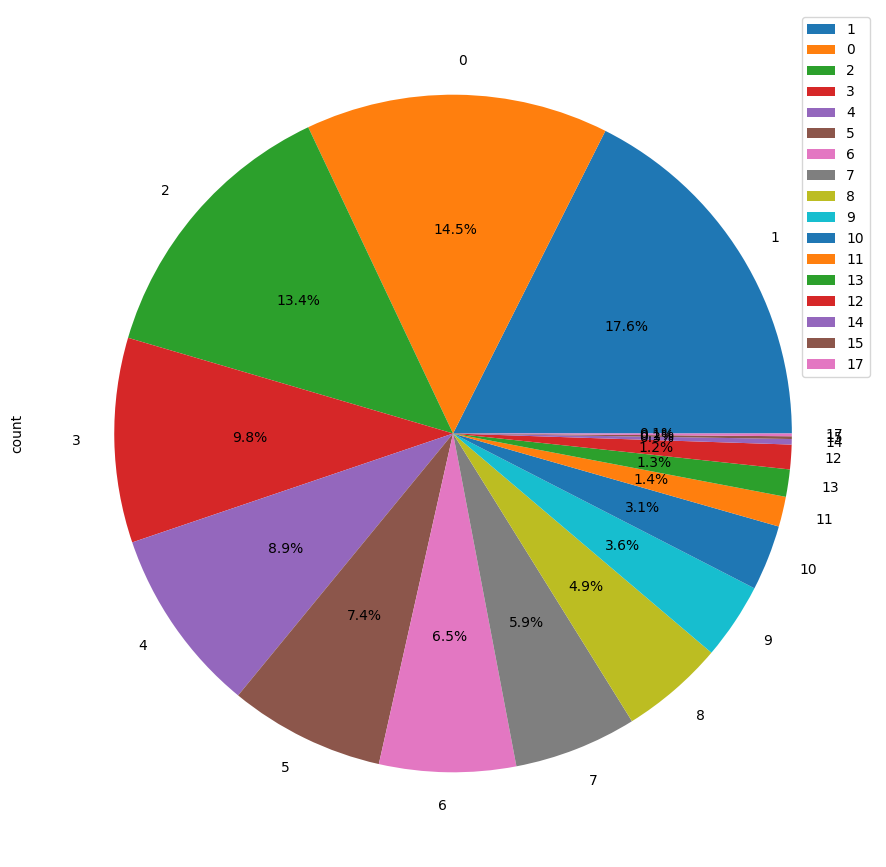

In [14]:
df_sym=pd.DataFrame(diabetes["Pregnancies"].value_counts())
print(df_sym)
df_sym.plot.pie(subplots=True,labels=df_sym.index.values,autopct="%1.1f%%",figsize=(20,11))
plt.show()

<Axes: xlabel='Outcome'>

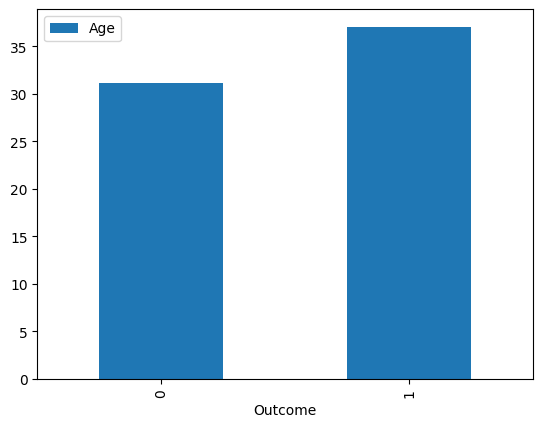

In [15]:
diabetes[["Age","Outcome"]].groupby("Outcome").mean().plot.bar()

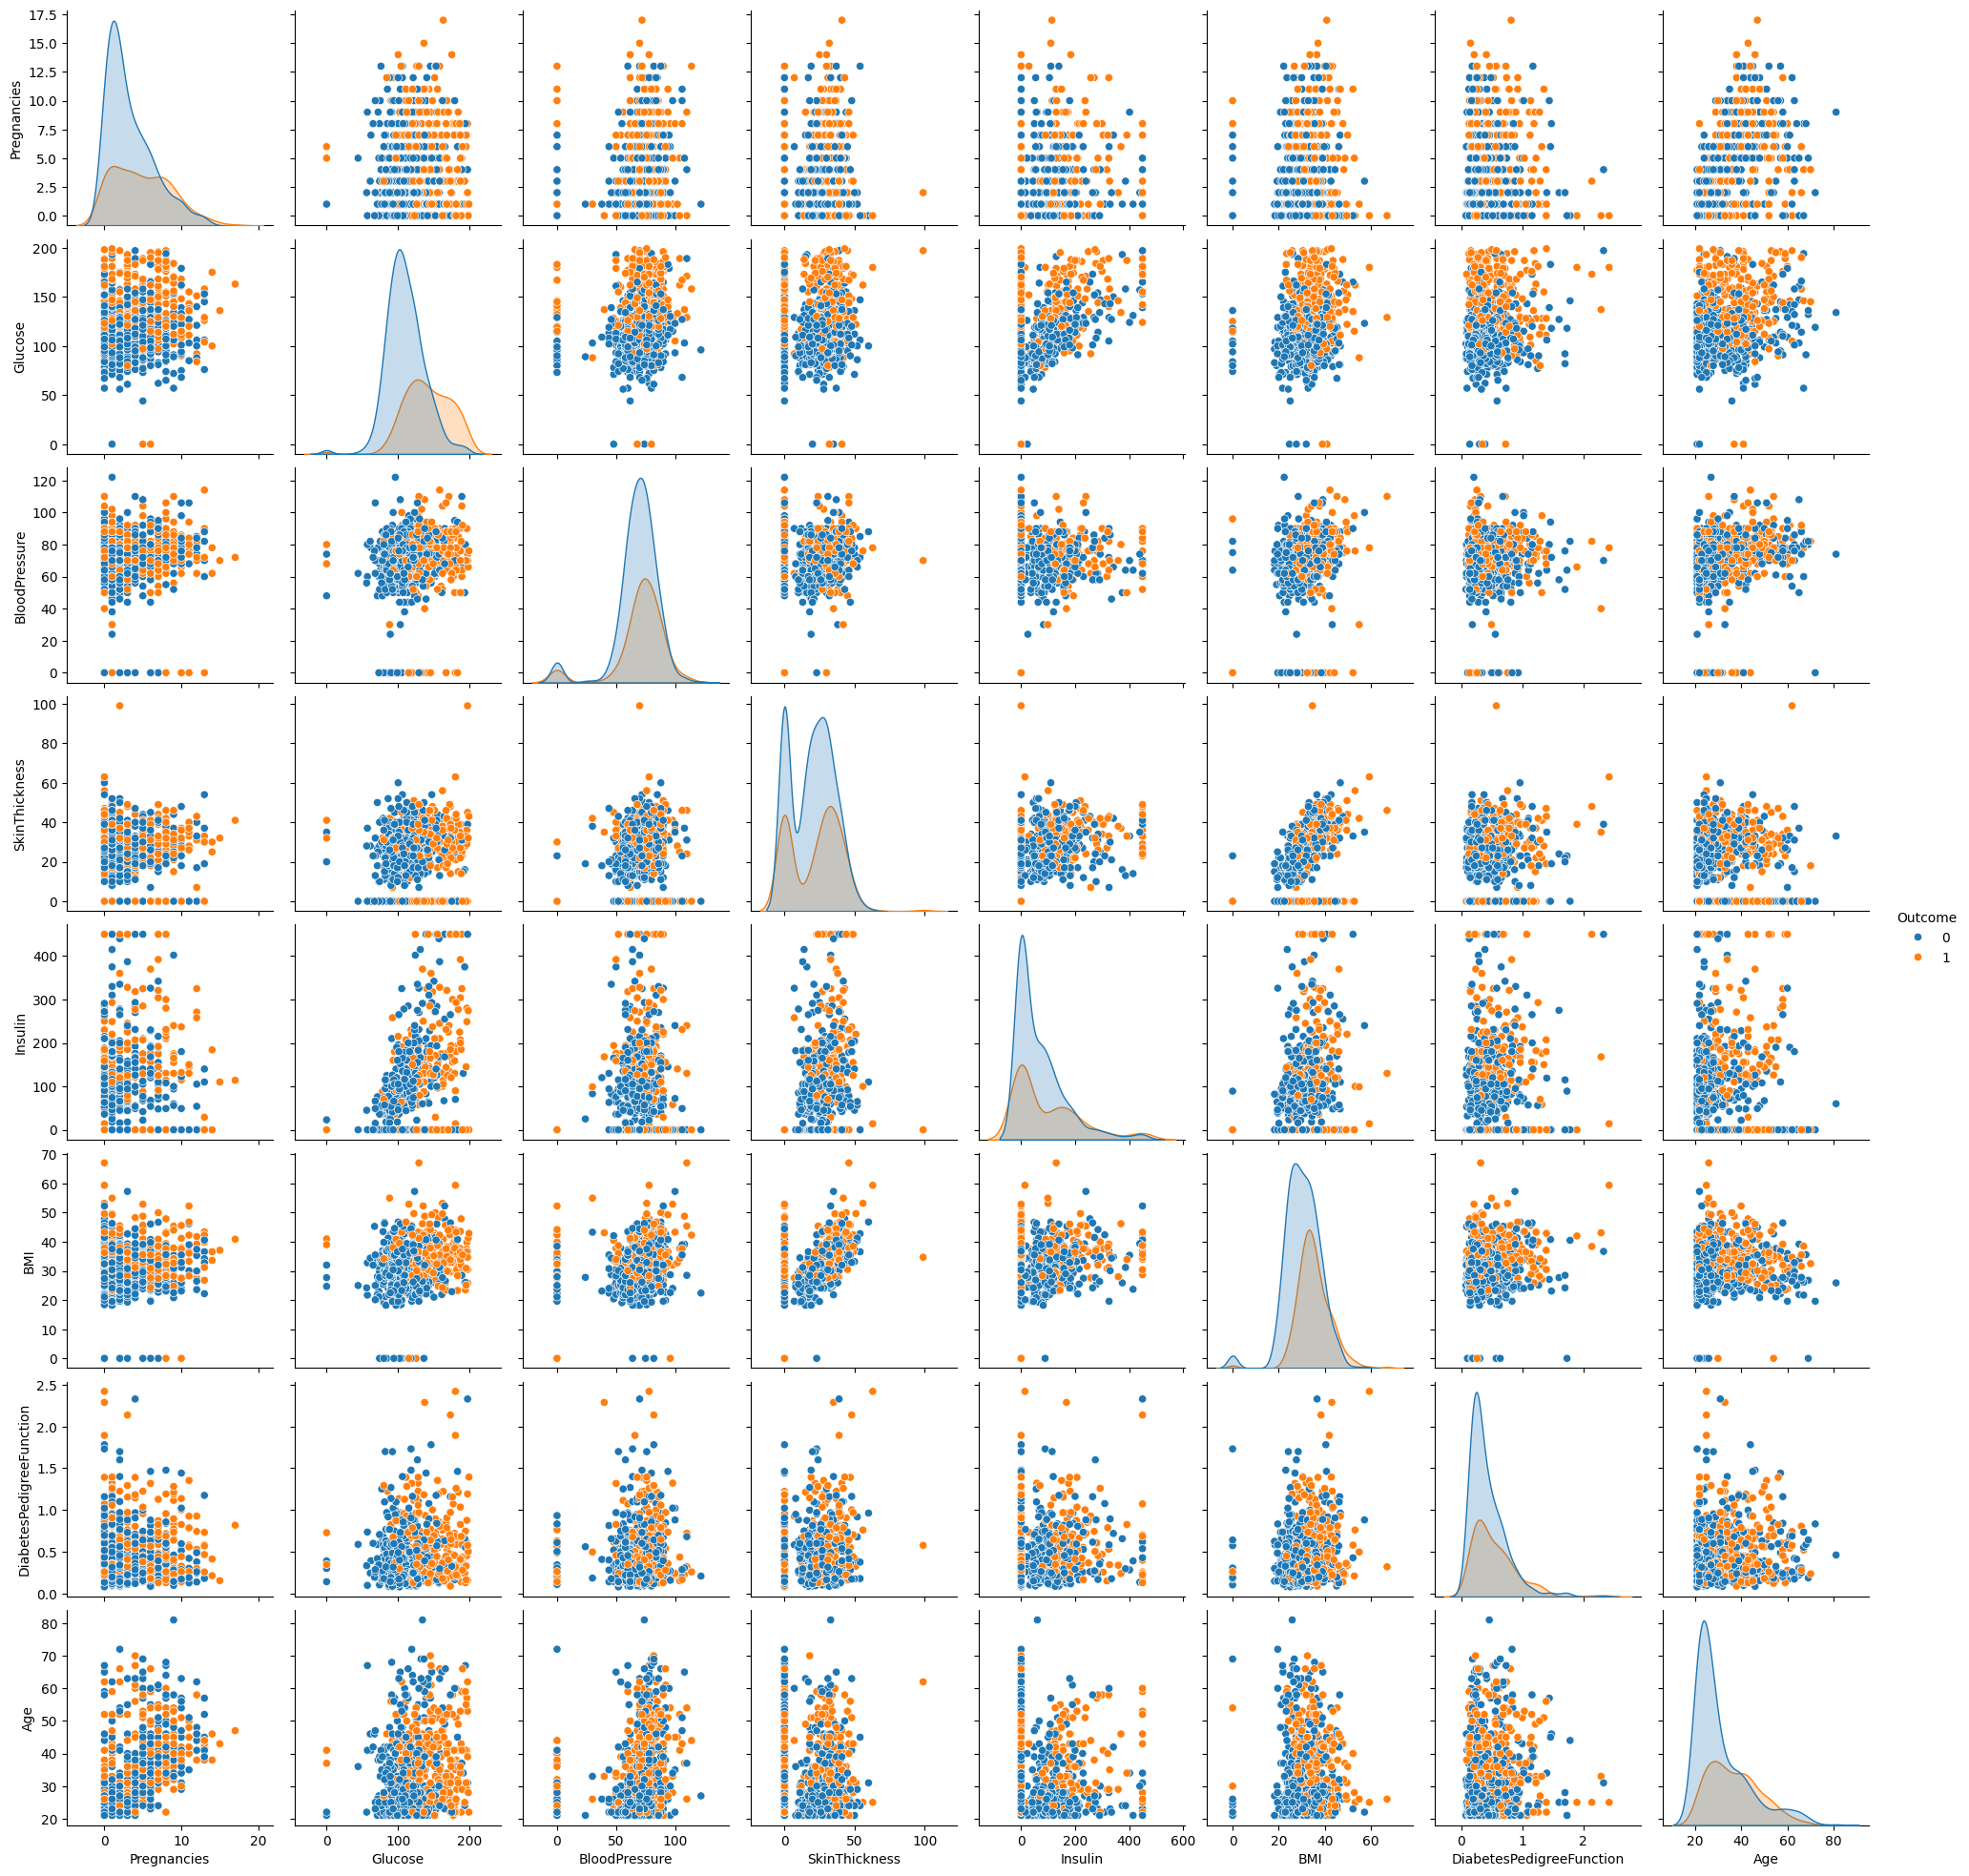

In [16]:
# Plot pairplot
sns.pairplot(diabetes, hue='Outcome')
plt.show()


<Axes: >

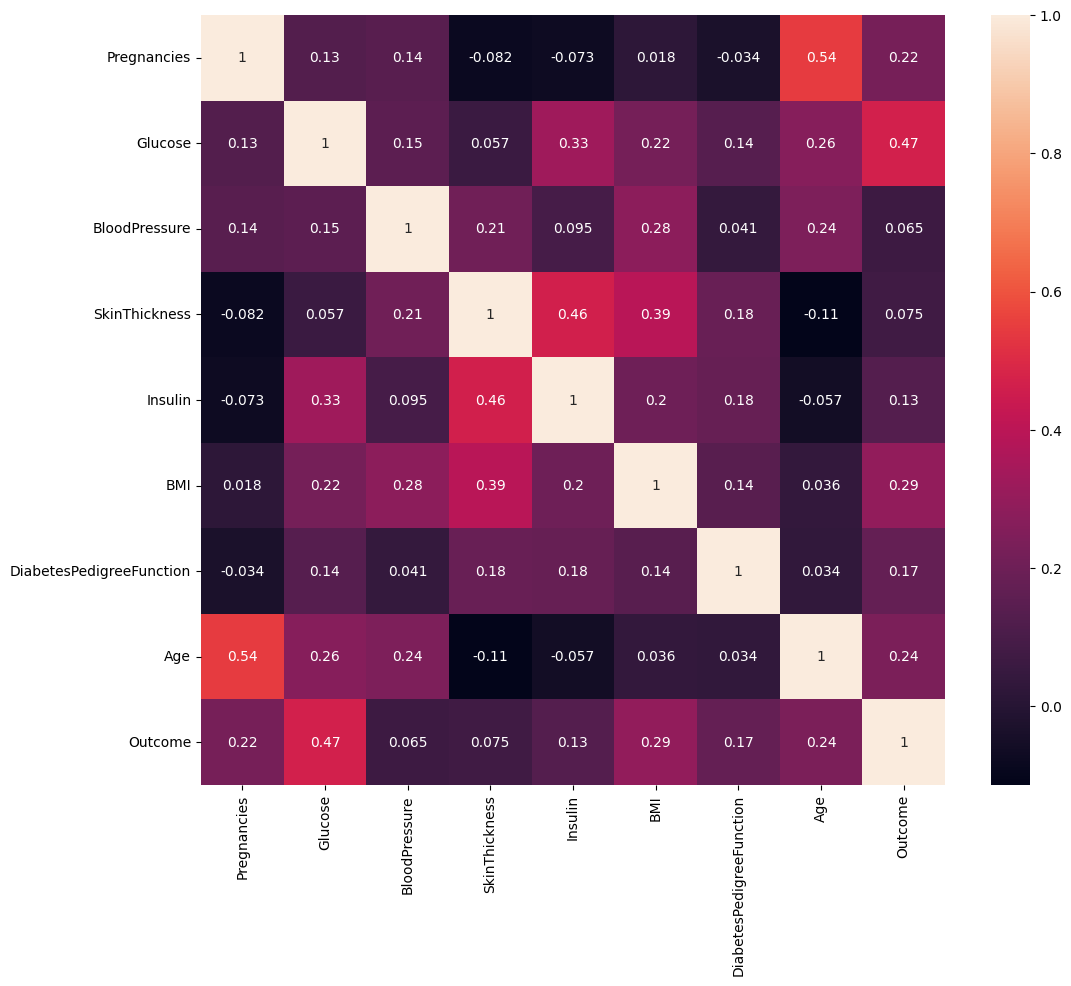

In [17]:
plt.figure(figsize = (12,10))

sns.heatmap(diabetes.corr(), annot =True)

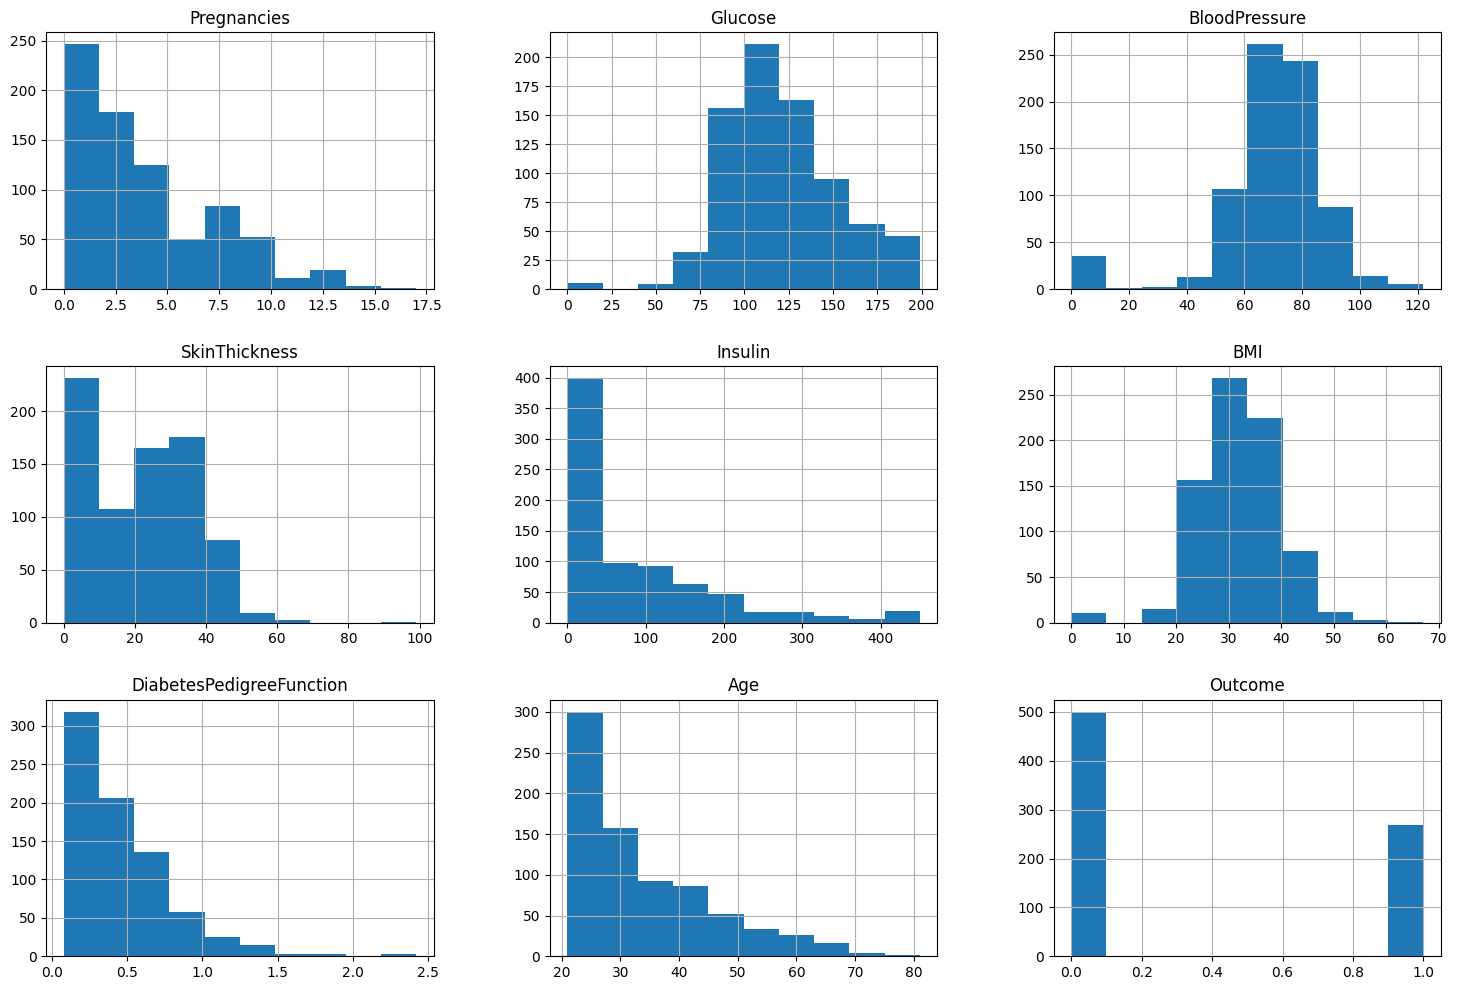

In [18]:
diabetes.hist(figsize=(18,12))
plt.show()

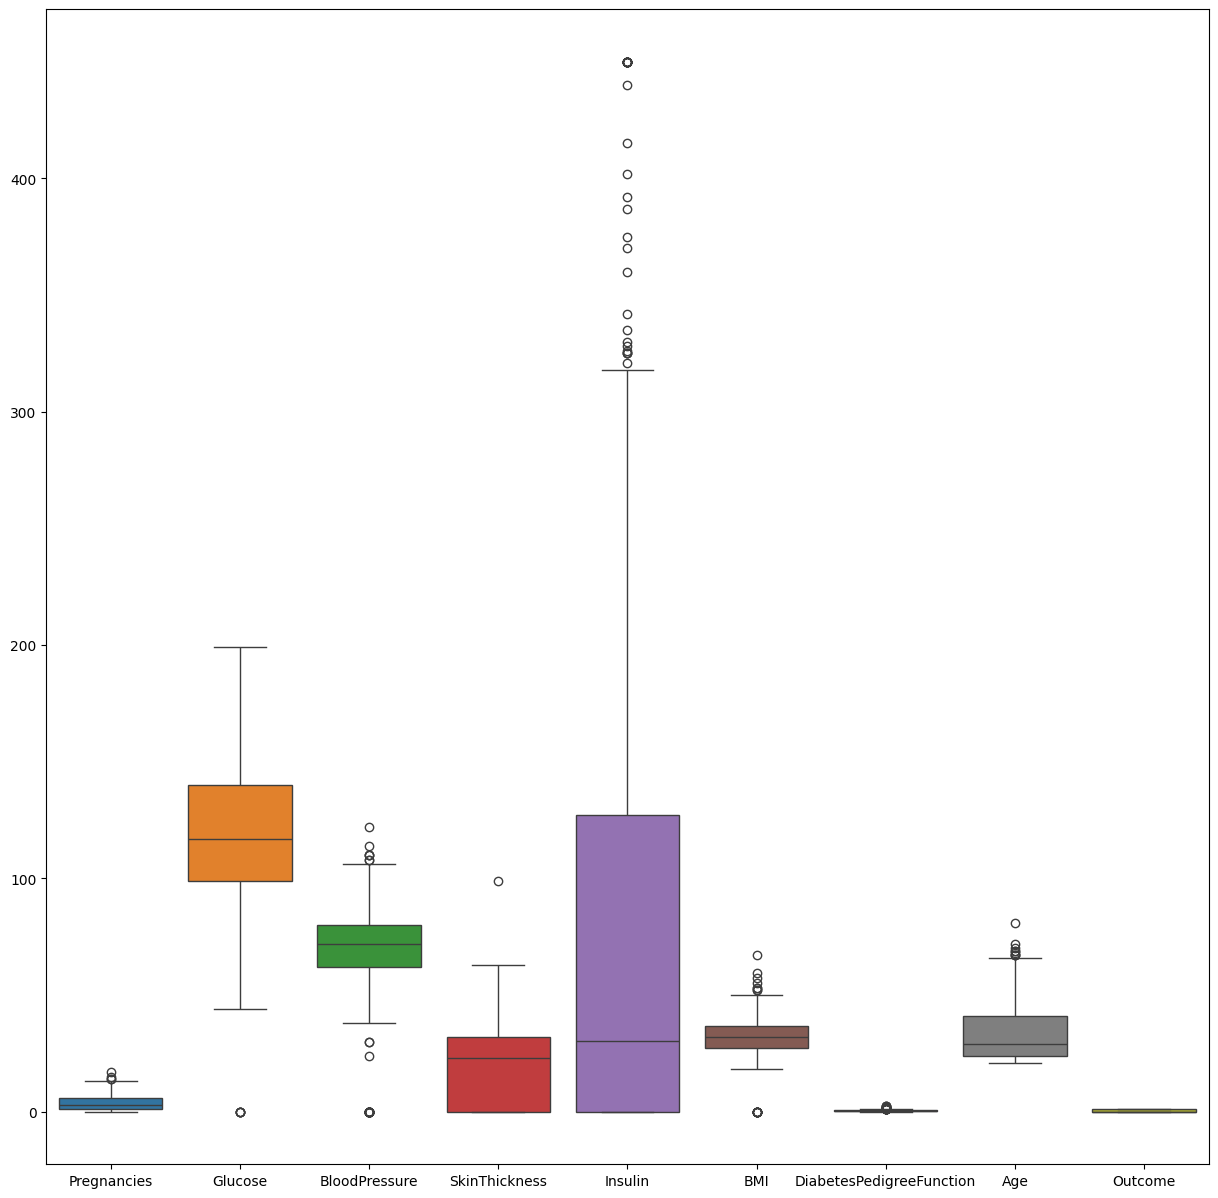

In [19]:
plt.figure(figsize=(15,15))

sns.boxplot(data=diabetes)

# Show the plot
plt.show()

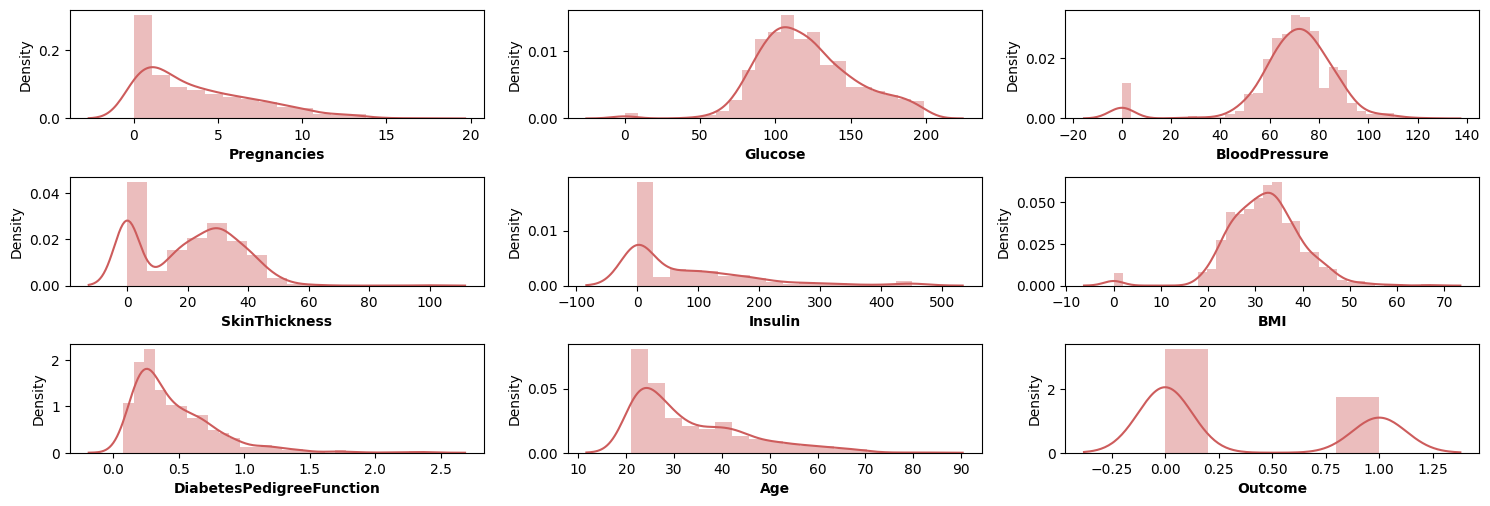

In [20]:
numeric_features = [feature for feature in diabetes.columns if diabetes[feature].dtype != 'O']
plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=diabetes[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

In [21]:
features = diabetes.drop('Outcome', axis=1)
labels = diabetes['Outcome']

# Split the data into training, validation, and test sets
TEST_SIZE = 0.2
RANDOM_STATE = 42

features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

In [22]:
# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(features_train)
X_test_scaled = scaler.transform(features_test)
X_train_scaled

array([[0.11764706, 0.42211055, 0.        , ..., 0.        , 0.09649872,
        0.        ],
       [0.52941176, 0.56281407, 0.67213115, ..., 0.42026826, 0.51409052,
        0.48333333],
       [0.05882353, 0.69849246, 0.37704918, ..., 0.42771982, 0.24594364,
        0.01666667],
       ...,
       [0.58823529, 0.50753769, 0.70491803, ..., 0.67958271, 0.45175064,
        0.28333333],
       [0.        , 0.70854271, 0.        , ..., 0.6318927 , 0.05422716,
        0.13333333],
       [0.        , 0.6281407 , 0.78688525, ..., 0.33532042, 0.07856533,
        0.        ]])

In [23]:
# Resample the training data
smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)
X_train_res, y_train_res = smt.fit_resample(X_train_scaled, labels_train)

In [24]:
# Prepare the train, valid, and test datasets for XGBoost
# Create DMatrix with feature names
dtrain = xgb.DMatrix(features_train, labels_train)
dtest = xgb.DMatrix(features_test, labels_test)

In [25]:
dtrain

In [26]:
# Original class distribution
original_class_distribution = pd.Series(labels).value_counts()
print("Original class distribution:")
print(original_class_distribution)

# Resampled class distribution
resampled_class_distribution = pd.Series(y_train_res).value_counts()
print("Resampled class distribution:")
print(resampled_class_distribution)


Original class distribution:
Outcome
0    500
1    268
Name: count, dtype: int64
Resampled class distribution:
Outcome
0    387
1    387
Name: count, dtype: int64


In [27]:
watchlist = [(dtrain, 'train')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.01
params['silent'] = True
params['max_depth'] = 9
params['subsample'] = 0.9
params['colsample_bytree'] = 0.8
params['eval_metric'] = 'auc'
params['n_estimators'] = 200
params['random_state'] = RANDOM_STATE

In [28]:
# Train the model with early stopping
xg_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,  # Adjust this as needed
    evals=watchlist,
    early_stopping_rounds=100,  # Adjust this as needed
    maximize=False,  # Use True if you want to maximize the metric
    verbose_eval=50  # Adjust this to control verbosity
)

[0]	train-auc:0.91720
[50]	train-auc:0.98806
[99]	train-auc:0.99168


In [29]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 200]
}

# Initialize an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', seed=RANDOM_STATE)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1)

In [30]:
# Fit the model using grid search
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='roc_auc', verbose=1)

In [31]:
# Get the best hyperparameters
best_params = grid_search.best_params_

In [32]:
best_params

{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 1.0}

In [33]:
# Train the XGBoost model with the best hyperparameters
best_model = xgb.train(best_params, dtrain, num_boost_round=150, evals=[(dtest, "Test")],
                       early_stopping_rounds=10)

[0]	Test-rmse:0.46536
[1]	Test-rmse:0.45513
[2]	Test-rmse:0.44546
[3]	Test-rmse:0.43751
[4]	Test-rmse:0.43185
[5]	Test-rmse:0.42717
[6]	Test-rmse:0.42149
[7]	Test-rmse:0.41636
[8]	Test-rmse:0.41384
[9]	Test-rmse:0.41194
[10]	Test-rmse:0.41020
[11]	Test-rmse:0.40688
[12]	Test-rmse:0.40418
[13]	Test-rmse:0.40324
[14]	Test-rmse:0.40079
[15]	Test-rmse:0.40076
[16]	Test-rmse:0.39997
[17]	Test-rmse:0.40104
[18]	Test-rmse:0.40029
[19]	Test-rmse:0.39968
[20]	Test-rmse:0.39979
[21]	Test-rmse:0.40057
[22]	Test-rmse:0.40173
[23]	Test-rmse:0.40208
[24]	Test-rmse:0.40182
[25]	Test-rmse:0.40232
[26]	Test-rmse:0.40345
[27]	Test-rmse:0.40354
[28]	Test-rmse:0.40376


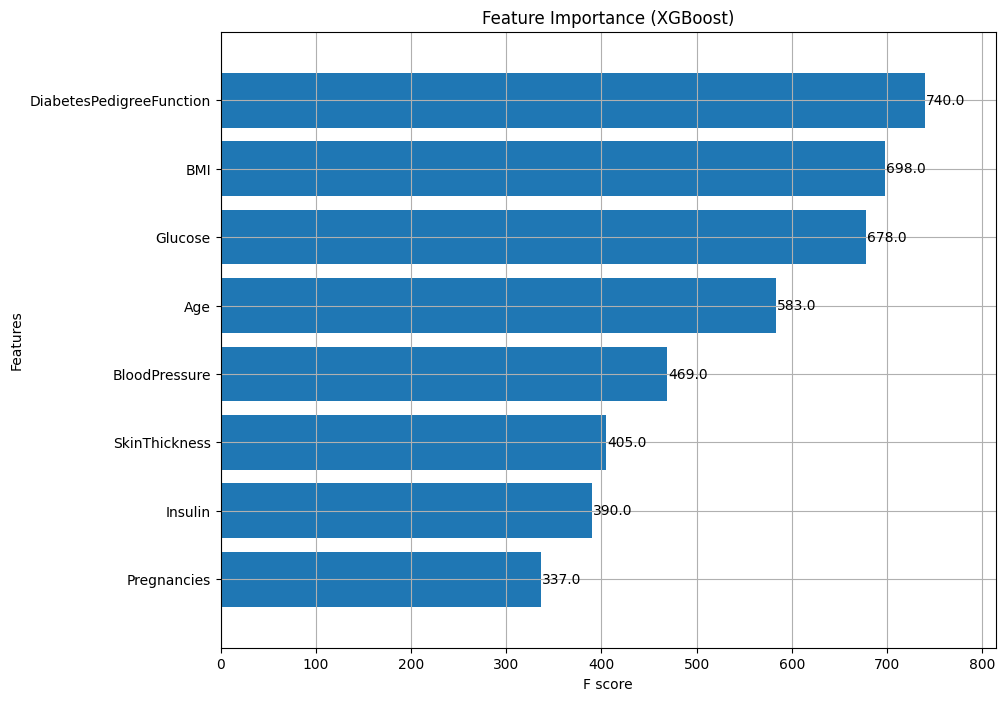

In [34]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xg_model, height=0.8, ax=ax, importance_type='weight', show_values=True)
plt.title("Feature Importance (XGBoost)")
plt.show()


In [35]:
# Make predictions on the test set
predictions = xg_model.predict(dtest)
predictions

array([0.43191233, 0.2788685 , 0.19444975, 0.22750036, 0.41048408,
       0.47102317, 0.1426853 , 0.57044756, 0.4711147 , 0.47630677,
       0.30710196, 0.62720543, 0.33819938, 0.4641257 , 0.17088732,
       0.3348308 , 0.19853973, 0.14854923, 0.46880588, 0.40013754,
       0.4821281 , 0.17697608, 0.28999156, 0.16803925, 0.45210823,
       0.68034214, 0.17888676, 0.15527341, 0.22149296, 0.22473697,
       0.5723794 , 0.564282  , 0.62371343, 0.62969077, 0.4681537 ,
       0.5245346 , 0.6397713 , 0.41630206, 0.31091776, 0.5247412 ,
       0.1990042 , 0.27179566, 0.55464983, 0.46677667, 0.16550979,
       0.55223435, 0.44687685, 0.22255765, 0.22717014, 0.66422004,
       0.14182943, 0.6227126 , 0.5433329 , 0.23633407, 0.19627984,
       0.14947282, 0.469559  , 0.15831189, 0.25054422, 0.63255394,
       0.5332724 , 0.27637354, 0.28608876, 0.29965475, 0.18409935,
       0.5189813 , 0.14517999, 0.45248762, 0.15131503, 0.595885  ,
       0.55573535, 0.21903835, 0.20489204, 0.16911083, 0.21655

In [36]:
#Convert probabilities to binary predictions (0 or 1)
binary_predictions = [1 if p > 0.5 else 0 for p in predictions]
binary_predictions

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0]

In [37]:
# Evaluate the model
accuracy = accuracy_score(labels_test, binary_predictions)
roc_auc = roc_auc_score(labels_test, predictions)
conf_matrix = confusion_matrix(labels_test, binary_predictions)

print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Accuracy: 0.7597
ROC AUC: 0.8059
Confusion Matrix:
[[88 11]
 [26 29]]


In [38]:
# Evaluate the model
accuracy = accuracy_score(labels_test, binary_predictions)
roc_auc = roc_auc_score(labels_test, predictions)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.7597
ROC AUC: 0.8059


In [39]:
# Make predictions
y_pred_proba = xg_model.predict(dtest)
y_pred = [1 if proba > 0.5 else 0 for proba in y_pred_proba]

# Calculate accuracy
accuracy = accuracy_score(labels_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7597


     Actual  Predicted
668       0          0
324       0          0
624       0          0
690       0          0
473       0          0
..      ...        ...
355       1          1
534       0          0
344       0          0
296       1          0
462       0          0

[154 rows x 2 columns]


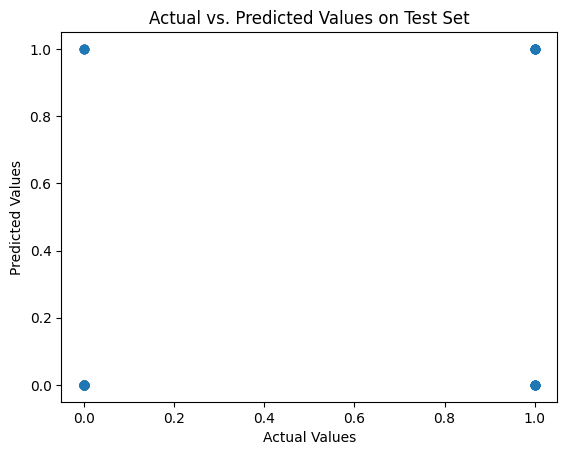

In [40]:
# Create a DataFrame
comparison_df = pd.DataFrame({'Actual': labels_test, 'Predicted': [1 if p > 0.5 else 0 for p in predictions]})

# Display the DataFrame
print(comparison_df)

# Plotting actual vs. predicted values
plt.scatter(labels_test, binary_predictions, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values on Test Set")
plt.show()

In [41]:

# Function to predict diabetes
def predict_diabetes():
    preg = int(input("Enter number of times pregnant: "))
    age = int(input("Enter age: "))
    glucose = int(input("Enter glucose level: "))
    blood_pressure = int(input("Enter blood pressure: "))
    skin_thickness = int(input("Enter skin thickness: "))
    insulin = int(input("Enter insulin level: "))
    bmi = float(input("Enter BMI: "))
    dpf = float(input("Enter diabetes pedigree function: "))

    user_data = np.array([[preg, glucose, blood_pressure, skin_thickness, insulin, bmi, dpf, age]])
    # User input
    print("User Data (Before Scaling):", user_data)

    # Scaling the data
    scaler = MinMaxScaler()
    scaler.fit(features_train)  # Fit on the training data
    user_data_scaled = scaler.transform(user_data)

    print("User Data (After Scaling):", user_data_scaled)

    # Convert to DMatrix with correct feature names
    duser = xgb.DMatrix(user_data_scaled, feature_names=features.columns.tolist())

    # Make predictions
    prediction_prob = xg_model.predict(duser)[0]
    prediction = 1 if prediction_prob > 0.5 else 0

    print(f"Prediction Probability: {prediction_prob}")
    print("Diabetes Prediction: Positive" if prediction == 1 else "Diabetes Prediction: Negative")

# Call the function to get user input and make prediction
predict_diabetes()

Enter number of times pregnant: 1
Enter age: 35
Enter glucose level: 88
Enter blood pressure: 66
Enter skin thickness: 29
Enter insulin level: 0
Enter BMI: 33.6
Enter diabetes pedigree function: 0.350
User Data (Before Scaling): [[ 1.   88.   66.   29.    0.   33.6   0.35 35.  ]]
User Data (After Scaling): [[0.05882353 0.44221106 0.54098361 0.46031746 0.         0.50074516
  0.11614005 0.23333333]]
Prediction Probability: 0.1559278666973114
Diabetes Prediction: Negative


In [42]:
diabetes


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [43]:
from lightgbm import LGBMClassifier

# Define the model
lgbm_model = LGBMClassifier()

In [44]:
# Define the parameter grid
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20]
}

In [45]:
# Setup the grid search
grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [46]:

# Perform the grid search
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Info] Number of positive: 387, number of negative: 387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 774, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [47]:
# Train the model with the best parameters
best_lgbm_model = LGBMClassifier(**best_params)
best_lgbm_model.fit(X_train_res, y_train_res)

[LightGBM] [Info] Number of positive: 387, number of negative: 387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 774, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMClassifier(n_estimators=200)

In [48]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Make predictions on the test set
y_pred_test = best_lgbm_model.predict(X_test_scaled)

# Calculate performance metrics
accuracy = accuracy_score(labels_test, y_pred_test)
f1 = f1_score(labels_test, y_pred_test)
precision = precision_score(labels_test, y_pred_test)
recall = recall_score(labels_test, y_pred_test)
roc_auc = roc_auc_score(labels_test, y_pred_test)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test ROC AUC Score: {roc_auc:.4f}")


Test Accuracy: 0.7143
Test F1 Score: 0.6393
Test Precision: 0.5821
Test Recall: 0.7091
Test ROC AUC Score: 0.7131


In [49]:
# Make predictions
y_pred_proba = best_lgbm_model.predict(X_test_scaled)
y_pred = [1 if proba > 0.5 else 0 for proba in y_pred_proba]

# Calculate accuracy
accuracy = accuracy_score(labels_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7143
